# Imports

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import seaborn as sns
from openTSNE import TSNE
import os
from tqdm import tqdm
import json
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from pathlib import Path


project_dir = Path(os.getcwd())
data_path = project_dir / "data"

# Exploratory Data Analysis (EDA)

In [71]:
df_path = data_path / "raw" / "train.csv"
df = pd.read_csv(df_path).drop_duplicates()
df['label'] = df['label'].apply(str.lower)

features = df.drop(['label'], axis=1)
target = df['label']

## Data Description

In [56]:
"""
Id: Unique identifier for each row in the test set.
flow_time: Duration of network flow.
header_size: Size of the packet headers.
packet_duration: Duration of individual packets.
overall_rate: Overall data transfer rate.
src_rate: Data transfer rate from the source.
dst_rate: Data transfer rate towards the destination.
fin_packets: Number of packets flagged as finished (FIN).
urg_packets: Number of urgent packets (URG).
rst_packets: Number of reset packets (RST).
max_value: Maximum value observed in packet data.
syn_flags: Number of SYN (synchronize) flags detected.
rst_flags: Number of RST (reset) flags detected.
psh_flags: Number of PSH (push) flags detected.
ack_flags: Number of ACK (acknowledge) flags detected.
protocol_http: Indicates HTTP protocol usage.
protocol_https: Indicates HTTPS protocol usage.
protocol_tcp: Indicates TCP protocol usage.
protocol_udp: Indicates UDP protocol usage.
protocol_icmp: Indicates ICMP protocol usage.
label (only in train.csv): Type of cyber-attack to be predicted (e.g., DDoS, DoS, benign).
"""
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 842396 entries, 0 to 938582
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   flow_time         842396 non-null  float64
 1   header_size       842396 non-null  float64
 2   packet_duration   842396 non-null  float64
 3   overall_rate      842396 non-null  float64
 4   src_rate          842396 non-null  float64
 5   dst_rate          842396 non-null  float64
 6   fin_packets       842396 non-null  float64
 7   urg_packets       842396 non-null  float64
 8   rst_packets       842396 non-null  float64
 9   max_value         842396 non-null  float64
 10  value_covariance  842396 non-null  float64
 11  fin_flags         842396 non-null  int64  
 12  syn_flags         842396 non-null  int64  
 13  rst_flags         842396 non-null  int64  
 14  psh_flags         842396 non-null  int64  
 15  ack_flags         842396 non-null  int64  
 16  protocol_http     842396 

In [57]:
df.describe().round(1)

,flow_time,header_size,packet_duration,overall_rate,src_rate,dst_rate,fin_packets,urg_packets,rst_packets,max_value,...,fin_flags,syn_flags,rst_flags,psh_flags,ack_flags,protocol_http,protocol_https,protocol_tcp,protocol_udp,protocol_icmp
count,842396.0,842396.0,842396.0,842396.0,842396.0,842396.0,842396.0,842396.0,842396.0,842396.0,...,842396.0,842396.0,842396.0,842396.0,842396.0,842396.0,842396.0,842396.0,842396.0,842396.0
mean,15.0,113434.7,84.5,6354.1,6354.1,0.0,0.1,6.5,41.4,190.2,...,0.1,0.2,0.1,0.1,0.1,0.0,0.1,0.6,0.2,0.1
std,6225.7,1901094.2,174.9,66452.4,66452.4,0.0,0.3,74.6,342.4,541.7,...,0.3,0.4,0.3,0.3,0.3,0.2,0.2,0.5,0.4,0.3
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,54.0,64.0,2.2,2.2,0.0,0.0,0.0,0.0,50.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,55.2,64.0,17.0,17.0,0.0,0.0,0.0,0.0,54.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
75%,0.1,5036.3,64.0,187.3,187.3,0.0,0.0,0.0,0.0,56.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
max,4930147.3,331117370.0,6525.7,7340032.0,7340032.0,0.8,19.5,4136.7,9331.5,30329.2,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## Classes Distribution

In [58]:
def describe_column(target_col:pd.Series) -> pd.DataFrame:
    overview = pd.DataFrame(target_col.value_counts()).reset_index()
    overview['percentage'] = overview['count'] / overview['count'].sum() * 100
    overview['percentage_str'] = overview['percentage'].apply(lambda x: f"{x:.2f}%")

    return overview


# how many classes do we have?
total_samples = len(df)
print(f"{len(target.unique())} unique labels")

# are the classes unbalanced?
quick_overview = describe_column(target)
quick_overview

6 unique labels


,label,count,percentage,percentage_str
0,ddos,597897,70.975764,70.98%
1,dos,158496,18.814904,18.81%
2,mirai,51273,6.086567,6.09%
3,benigntraffic,21985,2.609818,2.61%
4,recon,6432,0.763536,0.76%
5,mitm,6313,0.749410,0.75%


<BarContainer object of 6 artists>

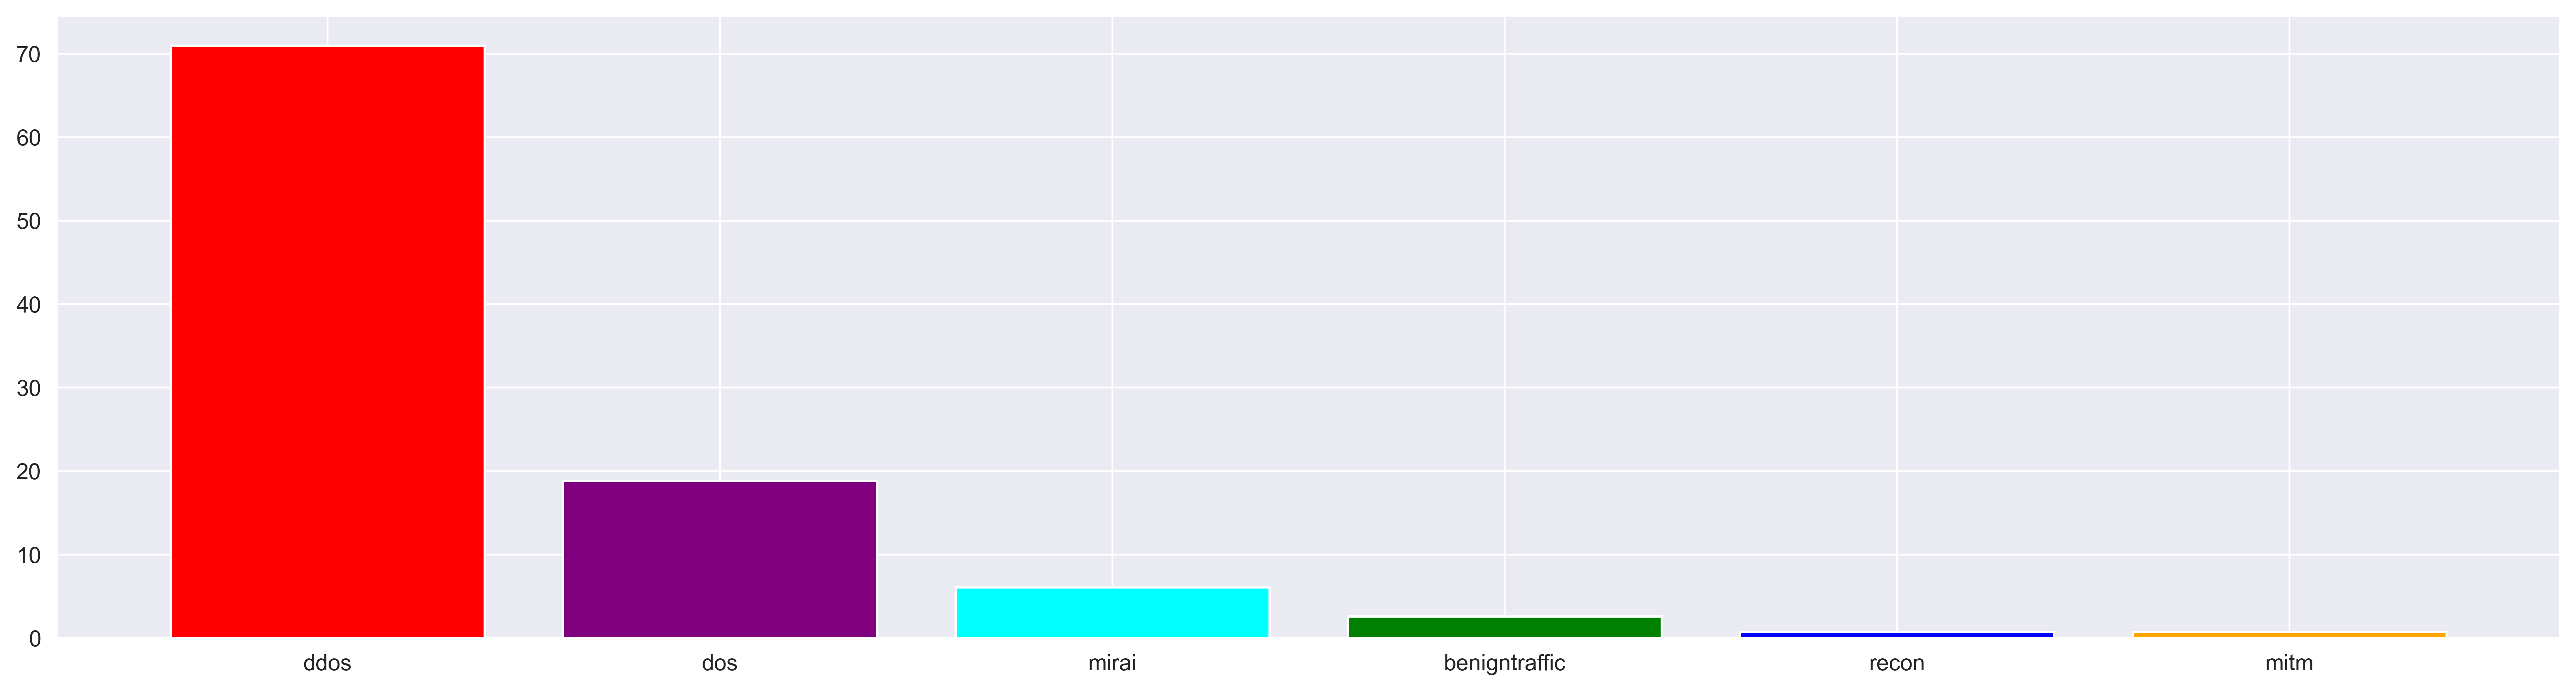

In [59]:
plt.figure(figsize=(20, 5), dpi=500)
plt.bar(
    quick_overview["label"], 
    height=quick_overview["percentage"] , 
    color= quick_overview["label"].replace({
        "ddos": "red",
        "recon": "blue",
        "benigntraffic": "green",
        "mitm": "orange",
        "dos": "purple",
        "mirai": "cyan"
    })
)

In [8]:
profile = ProfileReport(df, title="Profiling Report", explorative=True, lazy= True, minimal = True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 22/22 [00:01<00:00, 11.41it/s][A


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Outliers

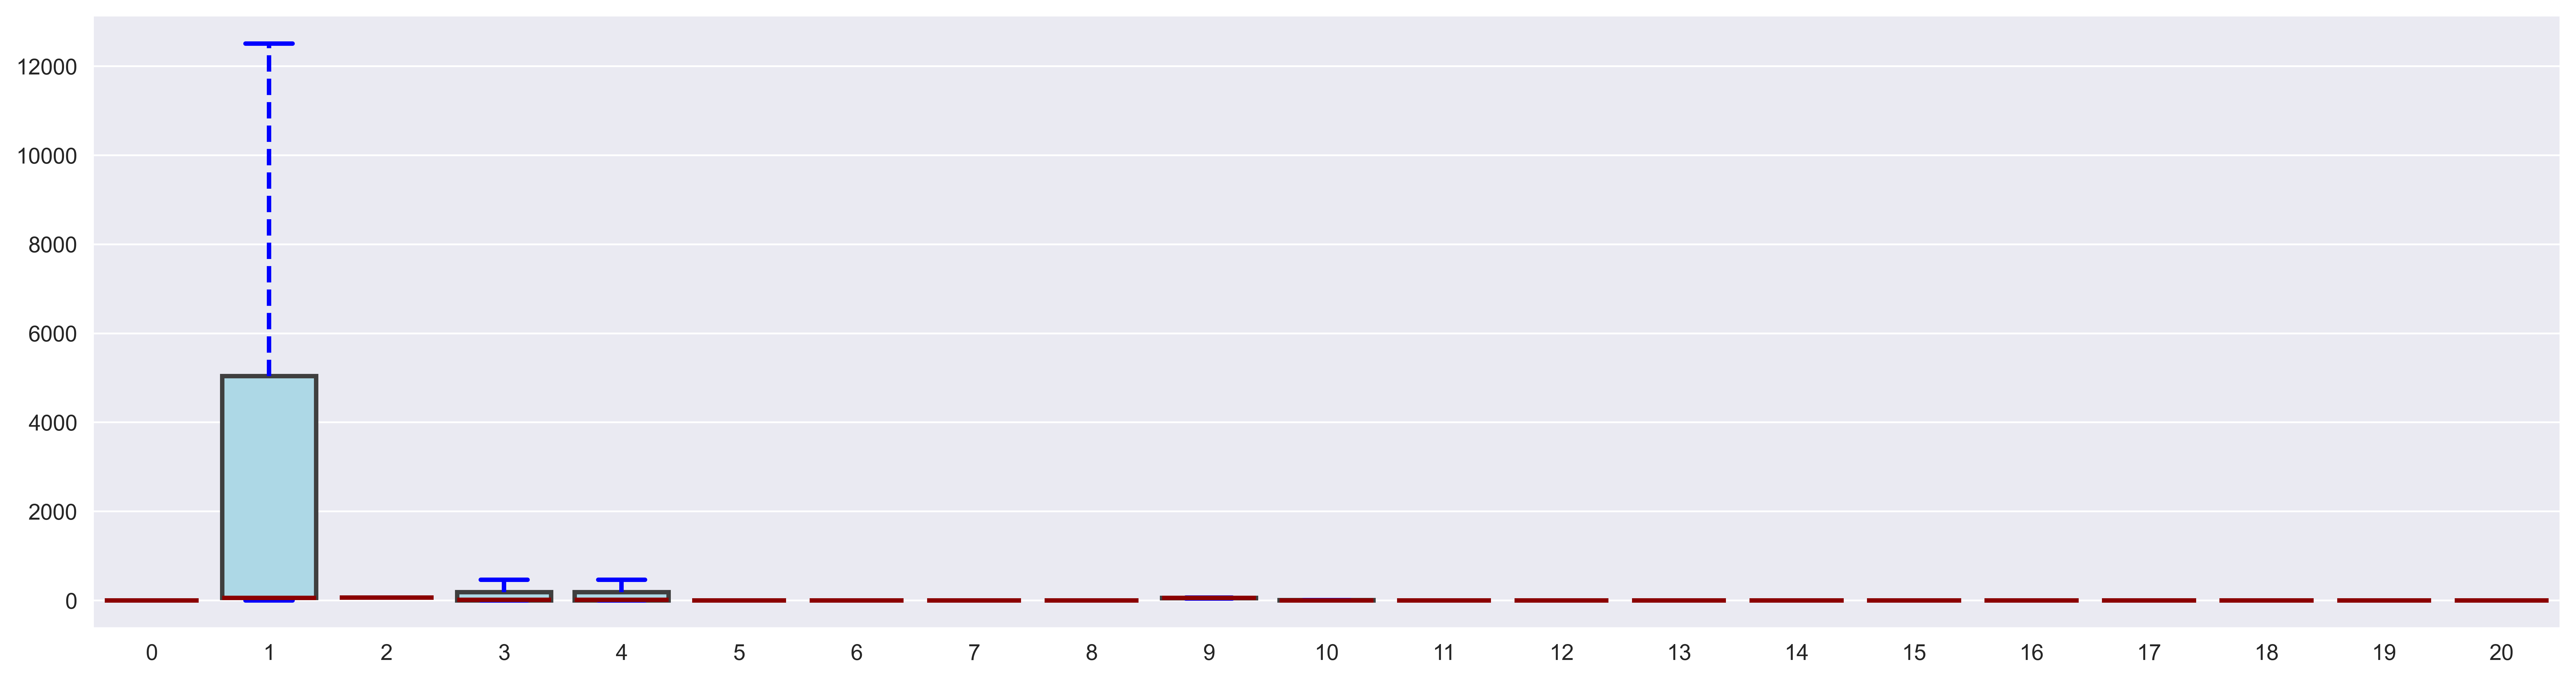

In [60]:
plt.figure(figsize=(20, 5), dpi=500)

sns.boxplot(
    data=features.to_numpy(),
    showfliers=False,  # hide extreme outliers
    boxprops=dict(facecolor="lightblue", linewidth=2),  # box styling
    whiskerprops=dict(color="blue", linewidth=2, linestyle="--"),
    medianprops=dict(color="darkred", linewidth=2),
    capprops=dict(color="blue", linewidth=2),
    # gap=1.5
)

plt.show()

In [61]:
df[[col for i, col in enumerate(df.columns) if i in [1, 3]]].describe().round(1)

,header_size,overall_rate
count,842396.0,842396.0
mean,113434.7,6354.1
std,1901094.2,66452.4
min,0.0,0.0
25%,54.0,2.2
50%,55.2,17.0
75%,5036.3,187.3
max,331117370.0,7340032.0


# Feature Selection

In [62]:
from sklearn.feature_selection import f_classif , SelectKBest

best_accuracy = -1
best_k = None
selected_features = None
selected_indices = None
k_values = range(1, len(features.columns) + 1)
accuracies = []
f1_scores = {
    "macro" : [], # all classes are equally important
    "weighted" : [], # weighted average based on classes frequencies (recommended for our dataset)
    "micro" : [], # best for overall performance across all samples
}

for k in tqdm(k_values):
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(features, target)
    new_features = selector.transform(features)

    rf = RandomForestClassifier(n_jobs=-1, random_state=0)
    rf.fit(new_features, target)
    y_pred = rf.predict(new_features)

    accuracy = accuracy_score(target, y_pred)
    accuracies.append(accuracy)
    f1_scores["macro"].append(f1_score(target, y_pred, average="macro"))
    f1_scores["micro"].append(f1_score(target, y_pred, average="micro"))
    f1_scores["weighted"].append(f1_score(target, y_pred, average="weighted"))

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k
        selected_indices = list(selector.get_support(indices=True))
        selected_features = list(df.columns[selected_indices])

print(f"Best k = {best_k}")
print(f"Best accuracy: {best_accuracy}")
print(f"- {len(selected_indices)} features selected")
print(f"- Selected features indices: {selected_indices}")
print(f"- Selected features: {selected_features}")

100%|██████████| 21/21 [21:34<00:00, 61.66s/it]

Best k = 20
Best accuracy: 0.9990384569727302
- 20 features selected
- Selected features indices: [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
- Selected features: ['flow_time', 'header_size', 'packet_duration', 'overall_rate', 'src_rate', 'fin_packets', 'urg_packets', 'rst_packets', 'max_value', 'value_covariance', 'fin_flags', 'syn_flags', 'rst_flags', 'psh_flags', 'ack_flags', 'protocol_http', 'protocol_https', 'protocol_tcp', 'protocol_udp', 'protocol_icmp']


<Axes: >

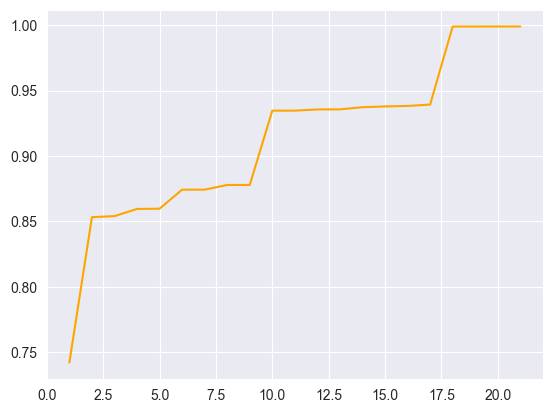

In [63]:
# accuracy plot
sns.lineplot(x=k_values, y=accuracies, color="orange")

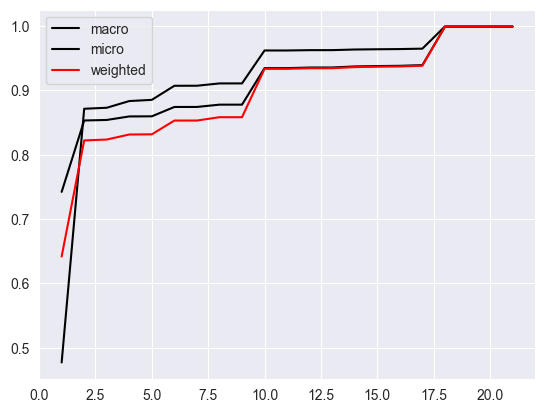

In [64]:
# f1-scores plot
sns.lineplot(x=k_values, y=f1_scores["macro"], label="macro", color="black")
sns.lineplot(x=k_values, y=f1_scores["micro"], label="micro", color="black")
sns.lineplot(x=k_values, y=f1_scores["weighted"], label="weighted", color="red")
plt.legend()
plt.show()

In [74]:
# save selected features
selected_features_path = data_path / "processed" / "selected_features.json"
with open(selected_features_path, "w") as f:
    json.dump(selected_features, f)

# Dimensionality Reduction

## PCA

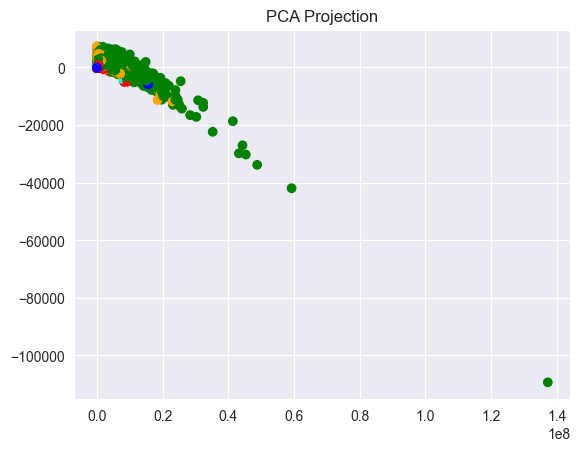

In [127]:
from sklearn.decomposition import PCA

colors_map = {
    "ddos": "red",
    "recon": "blue",
    "benigntraffic": "green",
    "mitm": "orange",
    "dos": "purple",
    "mirai": "cyan"
}

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[selected_features])

plt.scatter(x=pca_result[:, 0], y=pca_result[:, 1], c=target.replace(colors_map))
plt.title("PCA Projection")
plt.show()

In [129]:
from umap import UMAP

def visualize_data(X, y, method='pca') -> None:
    y = pd.Series(y)
    X = pd.DataFrame(X)
    colors_map = {
        "ddos": "red",
        "recon": "blue",
        "benigntraffic": "green",
        "mitm": "orange",
        "dos": "purple",
        "mirai": "cyan"
    }

    result = None
    title = None
    if method == 'pca':
        pca = PCA(n_components=2)
        result = pca.fit_transform(X)
        title = "PCA Projection"


    elif method == 'tsne':
        tsne = TSNE(
            n_components=2,
            perplexity=15,
            learning_rate=10,
            n_jobs=-1  # Use all available cores
        )
        result = tsne.fit(df[selected_features].to_numpy())
        title = "t-SNE Projection"

    elif method == 'umap':
        umap = UMAP(n_components=2, n_jobs=-1)
        result = umap.fit_transform(df[selected_features])
        title = "UMAP Projection"

    plt.scatter(x=result[:, 0], y=result[:, 1], c=y.replace(colors_map))
    plt.title(title)
    plt.show()

## UMAP

In [16]:
# from umap import UMAP
# umap = UMAP(n_components=2, n_jobs=-1)
# umap_data = umap.fit_transform(df[selected_features])
#
# plt.scatter(x=umap_data[:, 0], y=umap_data[:, 1], c=target.replace(colors_map))
# plt.title("PCA Projection")
# plt.show()

## t-SNE

In [17]:
# from openTSNE import TSNE
#
# tsne = TSNE(
#     n_components=2,
#     perplexity=15,
#     learning_rate=10,
#     n_jobs=-1  # Use all available cores
# )
#
# tsne_data = tsne.fit(df[selected_features].to_numpy())

In [18]:
# plt.scatter(x=tsne_data[:, 0], y=tsne_data[:, 1], c=target.replace(colors_map))
# plt.title("t-SNE Projection")
# plt.show()

# Classes Balancing

In [157]:
X = df[selected_features].to_numpy()
y = df["label"]
balance_point = 50_000

In [158]:
describe_column(target)

,label,count,percentage,percentage_str
0,ddos,687027,73.198321,73.20%
1,dos,163428,17.412205,17.41%
2,mirai,53395,5.688895,5.69%
3,benigntraffic,21987,2.342574,2.34%
4,recon,6433,0.685395,0.69%
5,mitm,6313,0.672610,0.67%


In [ ]:
from imblearn.over_sampling import SMOTEN as over_sampler
from imblearn.under_sampling import ClusterCentroids as under_sampler

to_under_sample = []
to_over_sample = []

for cls, count in target.value_counts().items():
    if count < balance_point:
        to_over_sample.append(cls)
    else:
        to_under_sample.append(cls)

rus = under_sampler(
    random_state=0,
    sampling_strategy={cls:balance_point for cls in to_under_sample},

)
X_resampled, y_resampled = rus.fit_resample(X, y)

ros = over_sampler(
    random_state=0,
    sampling_strategy={cls:balance_point for cls in to_over_sample},
)
X_resampled, y_resampled = ros.fit_resample(X_resampled, y_resampled)

In [150]:
describe_column(pd.Series(y_resampled))

,label,count,percentage,percentage_str
0,benigntraffic,10000,16.666667,16.67%
1,ddos,10000,16.666667,16.67%
2,dos,10000,16.666667,16.67%
3,mirai,10000,16.666667,16.67%
4,mitm,10000,16.666667,16.67%
5,recon,10000,16.666667,16.67%


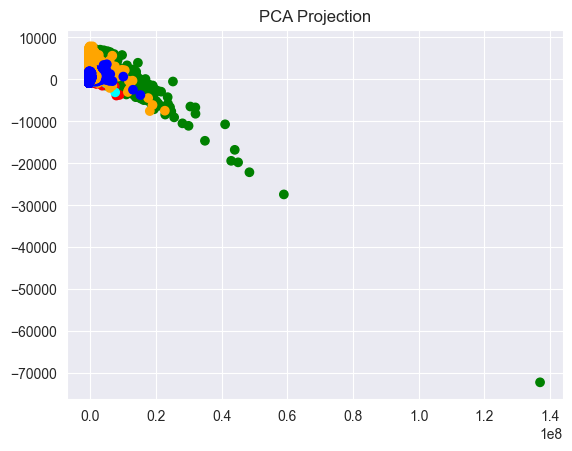

In [151]:
visualize_data(X_resampled, y_resampled)